# 03 - Baseline Modeling

Este notebook construye modelos  simples para predecir el éxito de un ensayo clínico.

### Modelos incluidos:
- DummyClassifier (baseline trivial)
- Logistic Regression
- Decision Tree

### Métricas:
- Accuracy
- Balanced Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC

### Visualizaciones:
- Matriz de confusión
- Curva ROC individual

In [128]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [129]:
DATA_PATH = Path("../data/processed/clinicaltrials_features_ml.csv")

PROJECT_ROOT = Path().resolve().parent
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"


df = pd.read_csv(DATA_PATH)
df.shape

(204675, 59)

In [130]:
df["target"] = np.nan
df.loc[df["OverallStatus_COMPLETED"] == 1, "target"] = 1
df.loc[df[["OverallStatus_TERMINATED", "OverallStatus_WITHDRAWN", "OverallStatus_SUSPENDED"]].sum(axis=1) > 0, "target"] = 0

df = df.dropna(subset=["target"]).copy()
df["target"] = df["target"].astype(int)

df["target"].value_counts(normalize=True)


target
1    0.813371
0    0.186629
Name: proportion, dtype: float64

In [131]:
features = ['PrimaryConditionMesh', 'DurationPrimaryDays',
       'DurationCompletionDays', 'StartYear', 'StartMonth',
       'StudyFirstSubmitYear', 'LastUpdateYear', 'PrimaryInterventionMesh',
       'EnrollmentCount', 'Sex_ALL', 'Sex_FEMALE', 'Sex_MALE', 'MinAgeYears',
       'MaxAgeYears', 'AgeRange', 'IsPediatric', 'IsElderly', 'IsRandomized',
       'IsBlinded', 'SummaryLength', 
       'LeadSponsorClass_FED', 'LeadSponsorClass_INDIV',
       'LeadSponsorClass_INDUSTRY', 'LeadSponsorClass_NETWORK',
       'LeadSponsorClass_NIH', 'LeadSponsorClass_OTHER',
       'LeadSponsorClass_OTHER_GOV', 'LeadSponsorClass_UNKNOWN',
       'Phase_PHASE1', 'Phase_PHASE1 / PHASE2', 'Phase_PHASE2',
       'Phase_PHASE2 / PHASE3', 'Phase_PHASE3', 'Phase_PHASE4',
       'DesignMasking_NONE', 'DesignMasking_QUADRUPLE', 'DesignMasking_SINGLE',
       'DesignMasking_TRIPLE', 'DesignMasking_Unknown',
       'PrimaryCountry_reduced_Canada', 'PrimaryCountry_reduced_China',
       'PrimaryCountry_reduced_Egypt', 'PrimaryCountry_reduced_France',
       'PrimaryCountry_reduced_Germany', 'PrimaryCountry_reduced_Japan',
       'PrimaryCountry_reduced_Other', 'PrimaryCountry_reduced_South Korea',
       'PrimaryCountry_reduced_United Kingdom',
       'PrimaryCountry_reduced_United States',
       'PrimaryCountry_reduced_Unknown']

X = df[features]
y = df["target"]

X.head()

,PrimaryConditionMesh,DurationPrimaryDays,DurationCompletionDays,StartYear,StartMonth,StudyFirstSubmitYear,LastUpdateYear,PrimaryInterventionMesh,EnrollmentCount,Sex_ALL,...,PrimaryCountry_reduced_China,PrimaryCountry_reduced_Egypt,PrimaryCountry_reduced_France,PrimaryCountry_reduced_Germany,PrimaryCountry_reduced_Japan,PrimaryCountry_reduced_Other,PrimaryCountry_reduced_South Korea,PrimaryCountry_reduced_United Kingdom,PrimaryCountry_reduced_United States,PrimaryCountry_reduced_Unknown
1,Neoplasm Metastasis,1174.0,1174.0,2021,10,2020,2025,Vemurafenib,72.0,1,...,False,False,False,True,False,False,False,False,False,False
2,"Dermatitis, Atopic",582.0,883.0,2019,9,2019,2025,spesolimab,14.0,1,...,False,False,False,False,False,False,False,False,True,False
3,Alzheimer Disease,31.0,31.0,2011,5,2010,2014,Galantamine,1.0,1,...,False,False,False,False,False,True,False,False,False,False
5,Thrombosis,930.0,930.0,2015,11,2015,2019,Rivaroxaban,47.0,1,...,False,False,False,False,False,False,False,False,True,False
7,Lung Neoplasms,444.0,526.0,2024,2,2024,2025,Unknown,10.0,1,...,False,False,False,False,False,False,False,False,True,False


In [132]:
numeric_features = [
    "DurationPrimaryDays", "DurationCompletionDays",
    "StartYear", "StartMonth", "StudyFirstSubmitYear", "LastUpdateYear",
    "EnrollmentCount", "MinAgeYears", "MaxAgeYears", "SummaryLength", "AgeRange"

]
binary_features = [
    "IsPediatric", "IsElderly", "IsRandomized", "IsBlinded"
]
categorical_features = [
    "PrimaryConditionMesh",
    "PrimaryInterventionMesh",
]
onehot_features = [
    "Sex_ALL", "Sex_FEMALE", "Sex_MALE",
    'LeadSponsorClass_FED', 'LeadSponsorClass_INDIV',
    'LeadSponsorClass_INDUSTRY', 'LeadSponsorClass_NETWORK',
    'LeadSponsorClass_NIH', 'LeadSponsorClass_OTHER',
    'LeadSponsorClass_OTHER_GOV', 'LeadSponsorClass_UNKNOWN',
    'Phase_PHASE1', 'Phase_PHASE1 / PHASE2', 'Phase_PHASE2',
    'Phase_PHASE2 / PHASE3', 'Phase_PHASE3', 'Phase_PHASE4',
    'DesignMasking_NONE', 'DesignMasking_QUADRUPLE',
    'DesignMasking_SINGLE', 'DesignMasking_TRIPLE',
    'DesignMasking_Unknown',
    'PrimaryCountry_reduced_Canada', 'PrimaryCountry_reduced_China',
    'PrimaryCountry_reduced_Egypt', 'PrimaryCountry_reduced_France',
    'PrimaryCountry_reduced_Germany', 'PrimaryCountry_reduced_Japan',
    'PrimaryCountry_reduced_Other', 'PrimaryCountry_reduced_South Korea',
    'PrimaryCountry_reduced_United Kingdom',
    'PrimaryCountry_reduced_United States',
    'PrimaryCountry_reduced_Unknown'
]

In [133]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [134]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("binary", "passthrough", binary_features),
        ("onehot", "passthrough", onehot_features),
    ]
)

In [135]:
def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba),
    }

    return metrics, y_pred, y_proba


In [136]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

m_dummy, y_pred_dummy, y_proba_dummy = evaluate(dummy, X_test, y_test, "Dummy")
m_dummy


{'model': 'Dummy',
 'accuracy': 0.8133720127089377,
 'balanced_accuracy': 0.5,
 'precision': 0.8133720127089377,
 'recall': 1.0,
 'f1': 0.8970823493562886,
 'roc_auc': 0.5}

In [137]:
logreg = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=10000, class_weight="balanced"))
])

logreg.fit(X_train, y_train)
m_logreg, y_pred_logreg, y_proba_logreg = evaluate(logreg, X_test, y_test, "LogisticRegression")
m_logreg


{'model': 'LogisticRegression',
 'accuracy': 0.6957452686835198,
 'balanced_accuracy': 0.6830685879823319,
 'precision': 0.9009028608724029,
 'recall': 0.7032948369565217,
 'f1': 0.7899279889360484,
 'roc_auc': 0.7476539541839982}

In [138]:
tree = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])

tree.fit(X_train, y_train)
m_tree, y_pred_tree, y_proba_tree = evaluate(tree, X_test, y_test, "DecisionTree")
m_tree


{'model': 'DecisionTree',
 'accuracy': 0.82829120044205,
 'balanced_accuracy': 0.7291145328390001,
 'precision': 0.9001205960892411,
 'recall': 0.8873556385869565,
 'f1': 0.8936925379516785,
 'roc_auc': 0.729114532839}

In [139]:
df_results = pd.DataFrame([m_dummy, m_logreg, m_tree])
df_results


,model,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,Dummy,0.813372,0.500000,0.813372,1.000000,0.897082,0.500000
1,LogisticRegression,0.695745,0.683069,0.900903,0.703295,0.789928,0.747654
2,DecisionTree,0.828291,0.729115,0.900121,0.887356,0.893693,0.729115


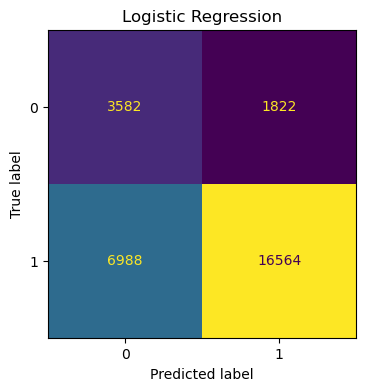

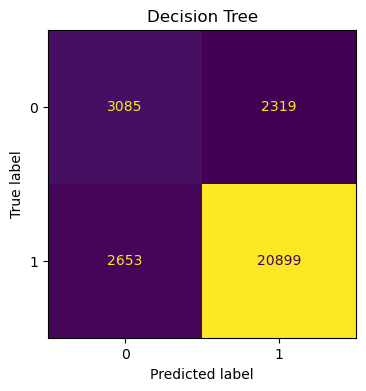

In [140]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)
    plt.savefig(FIGURES_DIR / F"{title}.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_conf_matrix(y_test, y_pred_logreg, "Logistic Regression")
plot_conf_matrix(y_test, y_pred_tree, "Decision Tree")


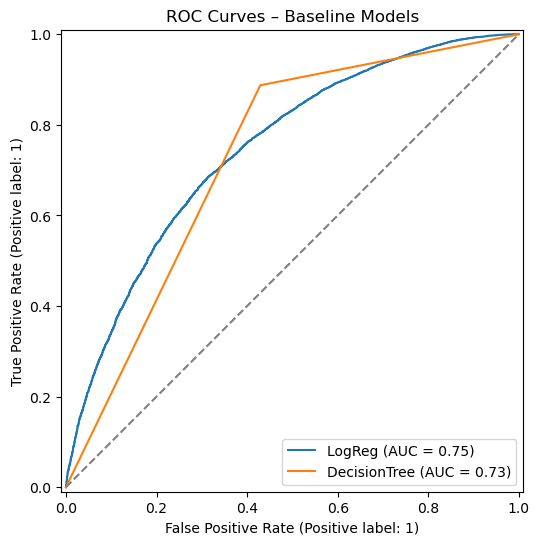

In [141]:
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_predictions(y_test, y_proba_logreg, name="LogReg", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_tree, name="DecisionTree", ax=ax)

ax.plot([0, 1], [0, 1], "--", color="gray")
ax.set_title("ROC Curves – Baseline Models")
plt.savefig(FIGURES_DIR / "roc_Baseline.png", dpi=300, bbox_inches="tight")
plt.show()


In [142]:
OUTPUT = Path("../reports/tables/baseline_metrics.csv")
df_results.to_csv(OUTPUT, index=False)
OUTPUT


WindowsPath('../reports/tables/baseline_metrics.csv')